# Novelty Detection & Classification

In this notebook, 200 2024 news with 50 from each industries serve as the testing data.

In [ ]:
from dotenv import load_dotenv
import os

load_dotenv()
os.environ["HUGGINGFACEHUB_API_TOKEN"] = os.getenv("HUGGINGFACEHUB_API_TOKEN")

# 失敗的話會列印出：'沒讀到 HUGGINGFACEHUB_API key'
os.environ["HUGGINGFACEHUB_API_TOKEN"]

## Read the Documents

In [2]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

doc_list = []
y_novelty_true = [1] * 200  # all documents are not outliers
y_classification_true = []

for i in range(1, 51):
    with open(f"./News/2024/semiconductors/{i}.txt", 'r', encoding='UTf-8') as file:
        doc_list.append(file.read())
        y_classification_true.append(1)  # semiconductors

for i in range(1, 51):
    with open(f"./News/2024/industrial_automation/{i}.txt", 'r', encoding='UTf-8') as file:
        doc_list.append(file.read())
        y_classification_true.append(2)  # industrial automation

for i in range(1, 51):
    with open(f"./News/2024/ev/{i}.txt", 'r', encoding='UTf-8') as file:
        doc_list.append(file.read())
        y_classification_true.append(3)  # ev

for i in range(1, 51):
    with open(f"./News/2024/AI/{i}.txt", 'r', encoding='UTf-8') as file:
        doc_list.append(file.read())
        y_classification_true.append(4)  # AI

## Zero-Shot Novelty Detection with Output Re-Check

In [3]:
from langchain.llms import HuggingFaceEndpoint
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from tqdm import tqdm


llm = HuggingFaceEndpoint(repo_id="mistralai/Mistral-7B-Instruct-v0.2", max_new_tokens=4096, temperature=0.1)

user_template = """
You are a professional business analyst. Please help me classify whether the following news delimited by <news> tags is relevant to the listed industries.
The listed industries are semiconductors, industrial automation, electric vehicle, and AI.

<news>
{news}
</news>

The output format is as follows, in JSON.

{{"category": <INTEGER_category>}}

The <INTEGER_category> to choose from are 1 (yes, the news is relevant to semiconductors, industrial automation, electric vehicle, or AI) and 0 (no, the news is not relevant to the listed industries).
Please output the category number ranging from 0 to 1, rather than the answer string.
Each news must belong to EXACTLY one category.
Please ONLY output the json and nothing else. You should strictly adhere to the output format!

Below is an example of a valid output:
{{"category": 0}}
"""

zeroshot_prompt = ChatPromptTemplate.from_messages([
    ("user", user_template)
])

C:\Users\ducky\anaconda3\Lib\site-packages\langchain_core\_api\deprecation.py:119: LangChainDeprecationWarning: The class `HuggingFaceEndpoint` was deprecated in LangChain 0.0.37 and will be removed in 0.3. An updated version of the class exists in the from langchain-huggingface package and should be used instead. To use it run `pip install -U from langchain-huggingface` and import as `from from langchain_huggingface import llms import HuggingFaceEndpoint`.
  warn_deprecated(


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to C:\Users\ducky\.cache\huggingface\token
Login successful


In [4]:
class Category(BaseModel):
    categoy: int = Field(description="the category number that the piece of news belongs to")


def get_json(text: str) -> str:
    index_start = text.find('{"')
    index_end = text.find('}', index_start)
    return text[index_start : (index_end + 1)]

parser = JsonOutputParser(pydantic_object=Category)

In [5]:
from langchain_core.prompts import ChatPromptTemplate

user_failed_template = """
The output format is illegal! Please re-generate a correct output.

The output format is as follows, in JSON.

{{"category": <INTEGER_category>}}

The <INTEGER_category> to choose from are 1 (yes, the news is relevant to semiconductors, industrial automation, electric vehicle, or AI) and 0 (no, the news is not relevant to the listed industries).
Please output the category number ranging from 0 to 1, rather than the answer string.
Each news must belong to EXACTLY one category.
Please ONLY output the json and nothing else.
"""

zeroshot_failed_prompt = ChatPromptTemplate.from_messages([
        ("user", user_template),
        ("ai", "{model_output}"),
        ("user", user_failed_template)
    ])

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to C:\Users\ducky\.cache\huggingface\token
Login successful


100%|██████████| 200/200 [05:06<00:00,  1.53s/it]


Number of invalid classifications: 2
Failed Outputs:
['\nBased on the news provided, the output would be:\n{"category": 3}\n\nThis news is about the development of an electric vehicle, specifically the Chevrolet Camaro EV. Therefore, the category number for this news is 3, which corresponds to the electric vehicle industry.', '\nBased on the provided news, the output would be:\n{"category": 3}\n\nThis news is about the updated Kia EV6 electric vehicle. It mentions the new battery pack, which could potentially increase the range of the vehicle, as well as some interior updates and new features. However, there is no mention of semiconductors, industrial automation, or AI in the news. Therefore, the correct output is {"category": 3}, indicating that this news is relevant to the electric vehicle industry.']
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00         0
           1       1.0

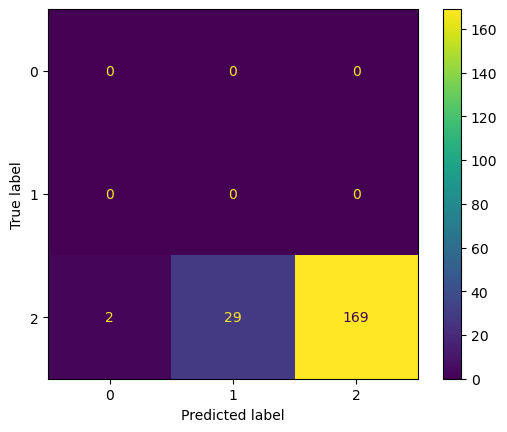

In [6]:
y_pred = []
failed_output = []

for doc in tqdm(doc_list):
    try:
        llm_output_chain = zeroshot_prompt | llm
        llm_output = llm_output_chain.invoke({"news": doc})
        json_chain = get_json | parser
        answer = json_chain.invoke(llm_output)
        assert((0 <= answer["category"] and answer["category"] <= 1))
        y_pred.append(answer["category"])
    except:
        try:
            llm_output_chain = zeroshot_failed_prompt | llm
            llm_output = llm_output_chain.invoke({"news": doc, "model_output": llm_output})
            json_chain = get_json | parser
            answer = json_chain.invoke(llm_output)
            assert((0 <= answer["category"] and answer["category"] <= 1))
            y_pred.append(answer["category"])
        except:
            y_pred.append(-1)
            failed_output.append(llm_output)

            
print("Number of invalid classifications:", y_pred.count(-1))
print("Failed Outputs:", failed_output, sep='\n')

print(classification_report(y_novelty_true, y_pred, zero_division=0.0))
confusion_mat = ConfusionMatrixDisplay(confusion_matrix(y_novelty_true, y_pred))
confusion_mat.plot()
plt.show()

## Zero-Shot Classification with Output Re-Check

In [7]:
user_template = """
You are a professional business analyst. Please help me classify by industry the following news delimited by <news> tags.
The possible industries are semiconductors, industrial automation, electric vehicle, and AI.

<news>
{news}
</news>

The output format is as follows, in JSON.

{{"category": <INTEGER_category>}}

The <INTEGER_category> to choose from are semiconductors (category: 1), industrial automation (category: 2), eletric vehicle (category: 3), and AI (category: 4).
Please output the category number ranging from 1 to 4, rather than the category name.
Each news must belong to EXACTLY one category.
Please ONLY output the json and nothing else. You should strictly adhere to the output format!

Below is an example of a valid output:
{{"category": 4}}
"""


user_failed_template = """
The output format is illegal! Please re-generate a correct output.

The output format is as follows, in JSON.

{{"category": <INTEGER_category>}}

The <INTEGER_category> to choose from are semiconductors (category: 1), industrial automation (category: 2), eletric vehicle (category: 3), and AI (category: 4).
Please output the category number ranging from 1 to 4, rather than the category name.
Each news must belong to EXACTLY one category.
Please ONLY output the json and nothing else. 
"""

In [8]:
zeroshot_prompt = ChatPromptTemplate.from_messages([
    ("user", user_template)
])


zeroshot_failed_prompt = ChatPromptTemplate.from_messages([
        ("user", user_template),
        ("ai", "{model_output}"),
        ("user", user_failed_template)
    ])

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to C:\Users\ducky\.cache\huggingface\token
Login successful


100%|██████████| 200/200 [12:24<00:00,  3.72s/it]


Number of invalid classifications: 0
Failed Outputs:
[]
              precision    recall  f1-score   support

           1       0.97      0.68      0.80        50
           2       0.90      0.90      0.90        50
           3       0.88      1.00      0.93        50
           4       0.84      0.98      0.91        50

    accuracy                           0.89       200
   macro avg       0.90      0.89      0.89       200
weighted avg       0.90      0.89      0.89       200



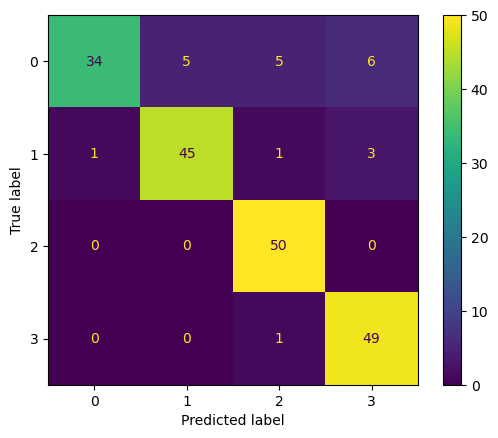

In [9]:
y_pred = []
failed_output = []

for doc in tqdm(doc_list):
    try:
        llm_output_chain = zeroshot_prompt | llm
        llm_output = llm_output_chain.invoke({"news": doc})
        json_chain = get_json | parser
        answer = json_chain.invoke(llm_output)
        assert((1 <= answer["category"] and answer["category"] <= 4))
        y_pred.append(answer["category"])
    except:
        try:
            llm_output_chain = zeroshot_failed_prompt | llm
            llm_output = llm_output_chain.invoke({"news": doc, "model_output": llm_output})
            json_chain = get_json | parser
            answer = json_chain.invoke(llm_output)
            assert((1 <= answer["category"] and answer["category"] <= 4))
            y_pred.append(answer["category"])
        except:
            y_pred.append(0)
            failed_output.append(llm_output)

            
print("Number of invalid classifications:", y_pred.count(0))
print("Failed Outputs:", failed_output, sep='\n')

print(classification_report(y_classification_true, y_pred, zero_division=0.0))
confusion_mat = ConfusionMatrixDisplay(confusion_matrix(y_classification_true, y_pred))
confusion_mat.plot()
plt.show()